In [ ]:
# 1. Install libraries (quietly)
!pip install google-play-scraper pyabsa pandas tqdm > /dev/null
!pip uninstall -y numpy > /dev/null
!pip install "numpy<2.0" > /dev/null

import torch
import warnings
import os
import pandas as pd
import re
import numpy as np
from google_play_scraper import Sort, reviews
from pyabsa import AspectTermExtraction as ATEPC

# Suppress warnings
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# GPU Check
if torch.cuda.is_available():
    print(f"✅ GPU Detected: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ WARNING: No GPU. Go to Runtime > Change runtime type > T4 GPU.")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.36.3 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tobler 0.13.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
rasterio 1.5.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version

In [ ]:
# --- 1. Fetch Reviews (ALL COLUMNS) ---
APP_ID = 'com.cgt.bharatgas'  # Hello BPCL App ID

print(f"Fetching reviews for {APP_ID}...")
# Fetches: reviewId, userName, userImage, content, score, thumbsUpCount,
# reviewCreatedVersion, at (date), replyContent, repliedAt, etc.
result, _ = reviews(
    APP_ID,
    lang='en',
    country='in',
    sort=Sort.NEWEST,
    count=200000 # <--- Change this to 82000 for your full project
)

# Convert to DataFrame (This keeps ALL columns automatically)
df = pd.DataFrame(result)

print(f"✅ Fetched {len(df)} reviews with {len(df.columns)} columns.")
print("Columns available:", df.columns.tolist())

# --- 2. Clean Data (But keep original rows intact) ---
def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s\.,!\?]', '', text)
    return re.sub(r'\s+', ' ', text).strip()

df['cleaned_review'] = df['content'].apply(clean_text)

# We filter for analysis, but we keep the original 'df' variable
# so we don't lose the metadata (Date, Rating, etc.)
# We create a mask for valid reviews (>3 words)
valid_mask = df['cleaned_review'].apply(lambda x: len(x.split()) > 3)
df_valid = df[valid_mask].copy()

print(f"✅ Analyzing {len(df_valid)} valid reviews...")

# --- 3. Run AI Analysis ---
aspect_extractor = ATEPC.AspectExtractor(checkpoint='multilingual', auto_device=True)

# Run prediction
results = aspect_extractor.batch_predict(
    target_file=df_valid['cleaned_review'].tolist(),
    save_result=False,
    print_result=False,
    pred_sentiment=True,
    batch_size=32
)

# --- 4. Merge Results with ALL Metadata ---
final_data = []

# We zip the dataframe rows with the results to keep everything aligned
for (index, row), output in zip(df_valid.iterrows(), results):

    # If aspects were found
    if output['aspect'] and output['aspect'] != ['']:
        for asp, sent in zip(output['aspect'], output['sentiment']):
            final_data.append({
                # --- The Analysis ---
                'Aspect': asp,
                'Sentiment': sent,

                # --- The Original Data (ALL COLUMNS) ---
                'Review_Text': row['content'],
                'Rating': row['score'],
                'Date': row['at'],
                'App_Version': row.get('reviewCreatedVersion', 'Unknown'),
                'Thumbs_Up': row['thumbsUpCount'],
                'User_Name': row['userName'],
                'Reply': row['replyContent']
            })

# Create final Rich DataFrame
final_df = pd.DataFrame(final_data)

# Save to CSV
filename = "HelloBPCL_Detailed_Analysis.csv"
final_df.to_csv(filename, index=False)

print(f"\n✅ SUCCESS! Saved '{filename}' with {len(final_df)} rows.")
print("Preview of the data:")
print(final_df[['Aspect', 'Sentiment', 'Rating', 'Date', 'Review_Text']].head())

Fetching reviews for com.cgt.bharatgas...
✅ Fetched 123582 reviews with 11 columns.
Columns available: ['reviewId', 'userName', 'userImage', 'content', 'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'appVersion']
✅ Analyzing 41415 valid reviews...
[2026-01-15 12:16:04] (2.4.2) ********** Available ATEPC model checkpoints for Version:2.4.2 (this version) **********
[2026-01-15 12:16:04] (2.4.2) ********** Available ATEPC model checkpoints for Version:2.4.2 (this version) **********
[2026-01-15 12:16:04] (2.4.2) Downloading checkpoint:multilingual 
[2026-01-15 12:16:04] (2.4.2) Notice: The pretrained model are used for testing, it is recommended to train the model on your own custom datasets
[2026-01-15 12:16:04] (2.4.2) Checkpoint already downloaded, skip
[2026-01-15 12:16:04] (2.4.2) Load aspect extractor from checkpoints/ATEPC_MULTILINGUAL_CHECKPOINT
[2026-01-15 12:16:04] (2.4.2) config: checkpoints/ATEPC_MULTILINGUAL_CHECKPOINT/fast_lcf_atepc.con

classifying aspect sentiments: 100%|██████████| 1161/1161 [07:36<00:00,  2.54it/s]



✅ SUCCESS! Saved 'HelloBPCL_Detailed_Analysis.csv' with 37124 rows.
Preview of the data:
    Aspect Sentiment  Rating                Date  \
0  payment  Negative       1 2026-01-14 08:10:41   
1  service  Positive       5 2026-01-14 06:55:29   
2      opt  Negative       2 2026-01-14 03:47:15   
3  service  Positive       5 2026-01-14 03:43:30   
4      app  Negative       1 2026-01-14 03:21:44   

                                         Review_Text  
0                     payment gateway issue very bad  
1  Best service from your side for necessary KYC ...  
2  I have to make mpine every time but opt doesn'...  
3             great experience and excellent service  
4  this app is a total waste of government money....  


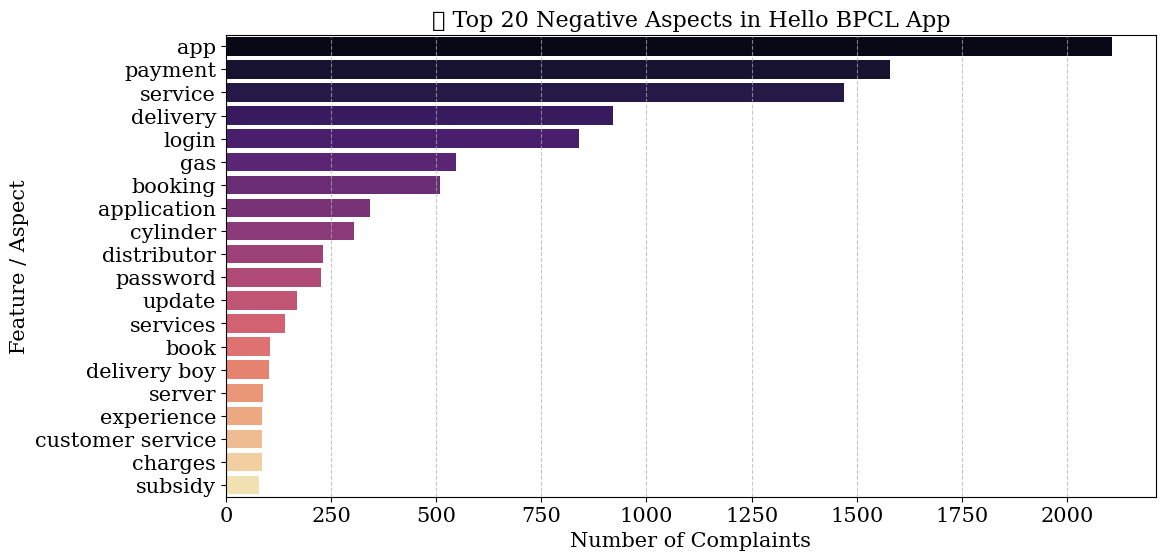

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Load your results
filename = "HelloBPCL_Detailed_Analysis.csv"
df = pd.read_csv(filename)

# 2. Filter for NEGATIVE sentiment only
# (We care more about what's broken than what works)
neg_df = df[df['Sentiment'] == 'Negative']

# 3. Count the most frequent negative aspects
top_complaints = neg_df['Aspect'].value_counts().head(20)

# 4. Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_complaints.values, y=top_complaints.index, palette='magma')
plt.title('🚨 Top 20 Negative Aspects in Hello BPCL App', fontsize=16)
plt.xlabel('Number of Complaints')
plt.ylabel('Feature / Aspect')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()